# intro

test fitting 'strain' ringdown with multiple modes.

fit late-inspiral, merger and post-peak with GPR

testing by hand for a few cases

In [1073]:
import qnm

# qnm.download_data()

In [1074]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [1075]:
import re
import glob
import os
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import numpy as np
import pandas as pd
import pathlib

In [1076]:
import nr_utils

In [1077]:
import lmfit

In [1078]:
import scipy.optimize

In [1079]:
import phenom

In [1080]:
### Need to modify this by the energy radiated as qnm assumes total mass of 1M i guess
def get_angular_ringdown_frequency_from_bbh(q, l, m, n=0):
    eta = phenom.eta_from_q(q)
    remnant_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    e_rad = phenom.remnant.EradRational0815(eta, 0, 0)

    mc = qnm.modes_cache(s=-2,l=l,m=m,n=n)
    omega, _, _ = mc(a=remnant_spin)
    return np.real(omega) / (1 - e_rad)
    
def get_angular_damping_frequency_from_bbh(q, l, m, n=0):
    eta = phenom.eta_from_q(q)
    remnant_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    e_rad = phenom.remnant.EradRational0815(eta, 0, 0)

    mc = qnm.modes_cache(s=-2,l=l,m=m,n=n)
    omega, _, _ = mc(a=remnant_spin)
    return -np.imag(omega) / (1 - e_rad)

In [1081]:
get_angular_ringdown_frequency_from_bbh(1, 2, 2)

0.5534656465229616

In [1082]:
get_angular_damping_frequency_from_bbh(1, 2, 2)

0.08542339187414541

In [1083]:
phenom.remnant.FinalSpin0815(0.25, 0, 0)

0.6864170524001022

In [1084]:
phenom.fring(0.25, 0, 0, 0.68)*2*np.pi

0.5506181900334295

In [1085]:
phenom.fdamp(0.25, 0, 0, 0.68)*2*np.pi

0.08565716198829981

In [1086]:
# sxs_list=[
#     # '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5',
#     # '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res3.h5'
#     '/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5',
# ]


In [1087]:
    
#     "/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5", #q=2
#     "/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5", #q=10


In [1088]:
lms = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5),(5,4)]

In [1089]:
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5" #q=4
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5" #q=5
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10
simname = nrfile.split('/')[-1].split('.h5')[0]
nrls = {}
for l, m in lms:
    nrls[l,m] = nr_utils.NRLoader(handler='nr_hdf5', nr_hdf5_filename=nrfile, dt=0.1, safety_factor=0.5, ell=l, mm=m)

In [1090]:
nrls[(2,2)].q

3.999987396038607

In [1091]:
nrls.keys()

dict_keys([(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3), (5, 5), (5, 4)])

In [1092]:
nrls[2,1].times

array([-3116.36311438, -3116.26311438, -3116.16311438, ...,
         403.23688562,   403.33688562,   403.43688562])

In [1093]:
nrls[2,1].strain

array([-4.08785385e-03+1.16844274e-03j, -4.09025675e-03+1.16019682e-03j,
       -4.09262277e-03+1.15195201e-03j, ...,
       -9.24548434e-08-4.89416920e-07j, -9.12935748e-08-4.89793999e-07j,
       -9.01422670e-08-4.90165134e-07j])

(-100.0, 100.0)

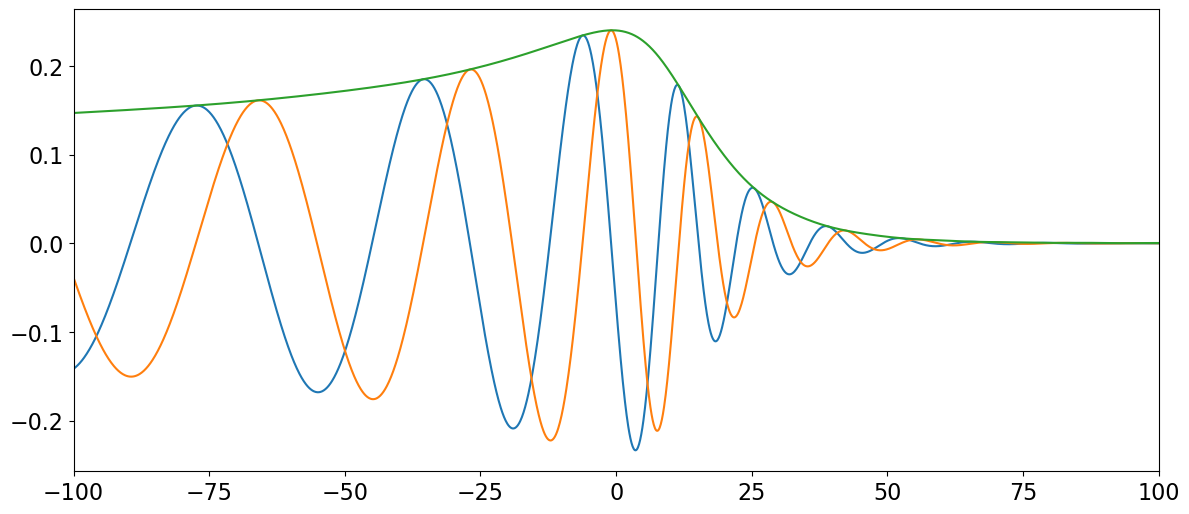

In [1094]:
plt.figure(figsize=(14,6))
plt.plot(nrls[2,2].times, nrls[2,2].strain.real)
plt.plot(nrls[2,2].times, nrls[2,2].strain.imag)
plt.plot(nrls[2,2].times, np.abs(nrls[2,2].strain))
plt.xlim(-100,100)

(-100.0, 100.0)

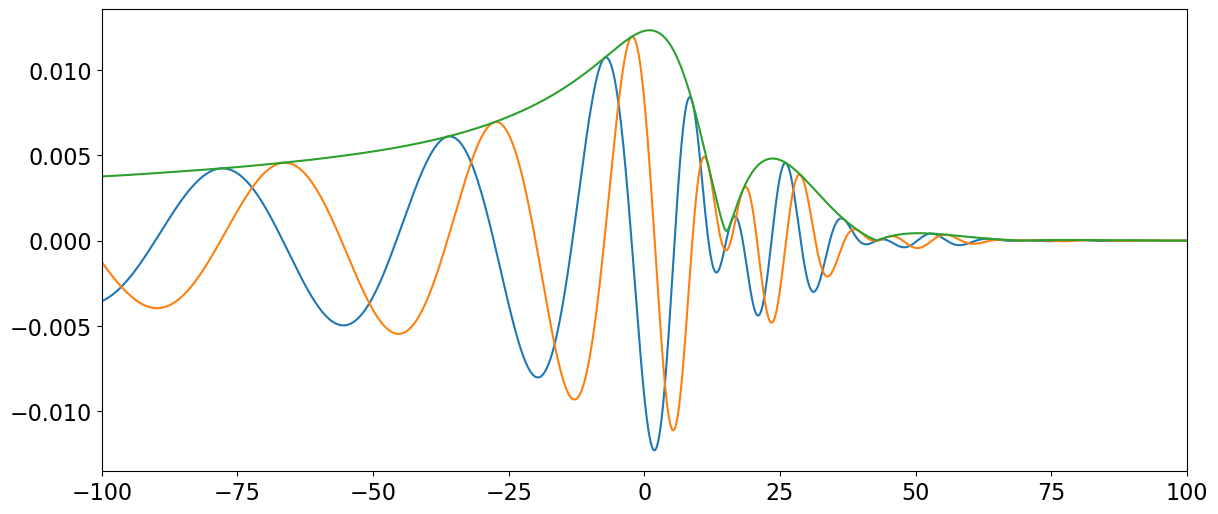

In [1095]:
plt.figure(figsize=(14,6))
plt.plot(nrls[3,2].times, nrls[3,2].strain.real)
plt.plot(nrls[3,2].times, nrls[3,2].strain.imag)
plt.plot(nrls[3,2].times, np.abs(nrls[3,2].strain))
plt.xlim(-100,100)

# modelling

In [1096]:
def ringdown_strain(x, t0, phi0, amp, omega, decay, sinusoid_fn=np.cos):
    """
    sinusoid_fn: either np.cos or np.sin depending on if you are fitting the real or imag part
    """
    # return amp * np.exp(-(x-t0)/decay) * sinusoid_fn(x*omega + phi0)
    return amp * np.exp(-(x-t0)/decay) * sinusoid_fn((x-t0)*omega + phi0)

In [1097]:
model_ringdown_strain = lmfit.Model(ringdown_strain)
                                    # prefix='_22_')

In [1098]:
model_ringdown_strain.independent_vars

['x']

In [1099]:
model_ringdown_strain.param_names

['t0', 'phi0', 'amp', 'omega', 'decay']

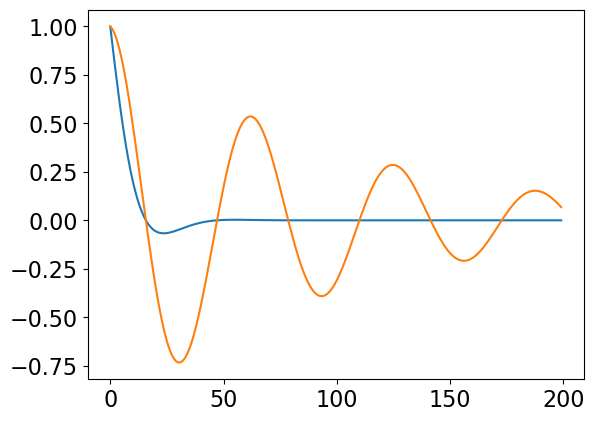

In [1100]:
plt.plot(model_ringdown_strain.eval(x=np.arange(0, 20, 0.1), t0=0, phi0=0, amp=1, omega=1, decay=1))
plt.plot(model_ringdown_strain.eval(x=np.arange(0, 20, 0.1), t0=0, phi0=0, amp=1, omega=1, decay=10))

In [1101]:
q = nrls[(2,2)].q
q

3.999987396038607

In [1102]:
x = nrls[2,2].times
y = nrls[2,2].strain.real

start_time = 30
end_time = 80

mask = np.where((x >= start_time) & (x <= end_time))
x=x[mask]
y=y[mask]

amp0 = float(IUS(x, np.abs(nrls[2,2].strain)[mask])(start_time))
amp0

0.0421079644479051

In [1103]:
params = model_ringdown_strain.make_params(
    t0=dict(value=start_time, vary=False),
    phi0=dict(value=0.5, min=-2*np.pi, max=2*np.pi),
    amp=dict(value=amp0, min=0, vary=False),
    omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,2,2), vary=False),
    decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 2, 2), vary=False)
)

In [1104]:
fr = model_ringdown_strain.fit(y, params, x=x, )

In [1105]:
fr.params

Parameters([('t0', <Parameter 't0', value=30 (fixed), bounds=[-inf:inf]>), ('phi0', <Parameter 'phi0', value=2.050545685579065 +/- 0.000694, bounds=[-6.283185307179586:6.283185307179586]>), ('amp', <Parameter 'amp', value=0.0421079644479051 (fixed), bounds=[0:inf]>), ('omega', <Parameter 'omega', value=0.4670321154532457 (fixed), bounds=[-inf:inf]>), ('decay', <Parameter 'decay', value=11.365163212454965 (fixed), bounds=[-inf:inf]>)])

<Axes: title={'center': 'Model(ringdown_strain)'}, xlabel='x', ylabel='y'>

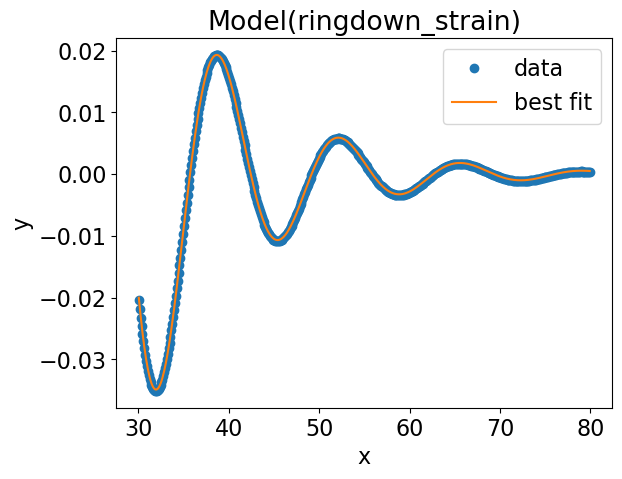

In [1106]:
fr.plot_fit()

<Axes: title={'center': 'Model(ringdown_strain)'}, ylabel='residuals'>

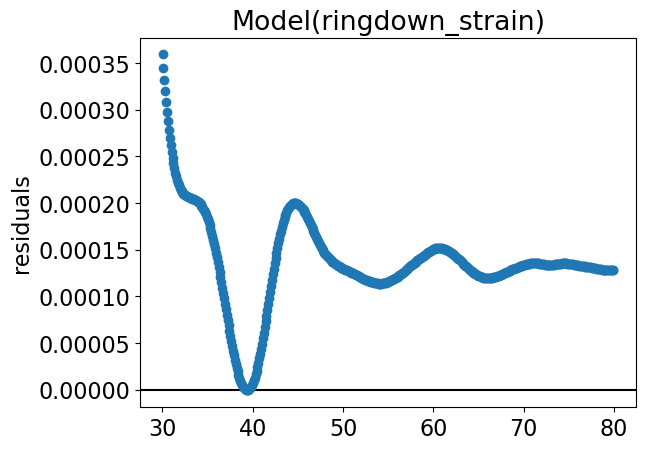

In [1107]:
fr.plot_residuals()

In [1108]:
model_ringdown_strain_32 = (
    lmfit.Model(ringdown_strain, prefix='_22_')
    + lmfit.Model(ringdown_strain, prefix='_32_')
)

In [1109]:
model_ringdown_strain_32

<lmfit.Model: (Model(ringdown_strain, prefix='_22_') + Model(ringdown_strain, prefix='_32_'))>

In [1110]:
x = nrls[3,2].times
y = nrls[3,2].strain.real

start_time = 30
end_time = 90

mask = np.where((x >= start_time) & (x <= end_time))
x=x[mask]
y=y[mask]

amp0 = np.abs(nrls[3,2].strain)[mask][0]

In [1111]:
# strategy to fit the data is to let all / most parameters be free to find phi0 best values
# then re-fit with RD freq and damp fixed?

In [1112]:
params = model_ringdown_strain_32.make_params(
    # 22
    _22_t0=dict(value=start_time, min=-10, vary=False),
    _22_phi0=dict(value=np.random.uniform(-1, 1), min=-2*np.pi, max=2*np.pi),
    _22_amp=dict(value=amp0, min=0),
    _22_omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,2,2), vary=False),
    _22_decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 2, 2), vary=False),
    # 32
    _32_t0=dict(value=start_time, min=-10, vary=False),
    _32_phi0=dict(value=np.random.uniform(-1, 1), min=-2*np.pi, max=2*np.pi),
    _32_amp=dict(value=amp0/2, min=0),
    _32_omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,3,2), vary=False),
    _32_decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 3, 2), vary=False),
)
params

Parameters([('_22_t0', <Parameter '_22_t0', value=30 (fixed), bounds=[-10:inf]>), ('_22_phi0', <Parameter '_22_phi0', value=0.2090270447313909, bounds=[-6.283185307179586:6.283185307179586]>), ('_22_amp', <Parameter '_22_amp', value=0.0034483359343260938, bounds=[0:inf]>), ('_22_omega', <Parameter '_22_omega', value=0.4670321154532457 (fixed), bounds=[-inf:inf]>), ('_22_decay', <Parameter '_22_decay', value=11.365163212454965 (fixed), bounds=[-inf:inf]>), ('_32_t0', <Parameter '_32_t0', value=30 (fixed), bounds=[-10:inf]>), ('_32_phi0', <Parameter '_32_phi0', value=0.7946962100717847, bounds=[-6.283185307179586:6.283185307179586]>), ('_32_amp', <Parameter '_32_amp', value=0.0017241679671630469, bounds=[0:inf]>), ('_32_omega', <Parameter '_32_omega', value=0.7015200993517197 (fixed), bounds=[-inf:inf]>), ('_32_decay', <Parameter '_32_decay', value=10.899890475345293 (fixed), bounds=[-inf:inf]>)])

In [1113]:
fr = model_ringdown_strain_32.fit(y, params, x=x)

In [1114]:
fr

<Axes: title={'center': "(Model(ringdown_strain, prefix='_22_') + Model(ringdown_strain, prefix='_32_'))"}, xlabel='x', ylabel='y'>

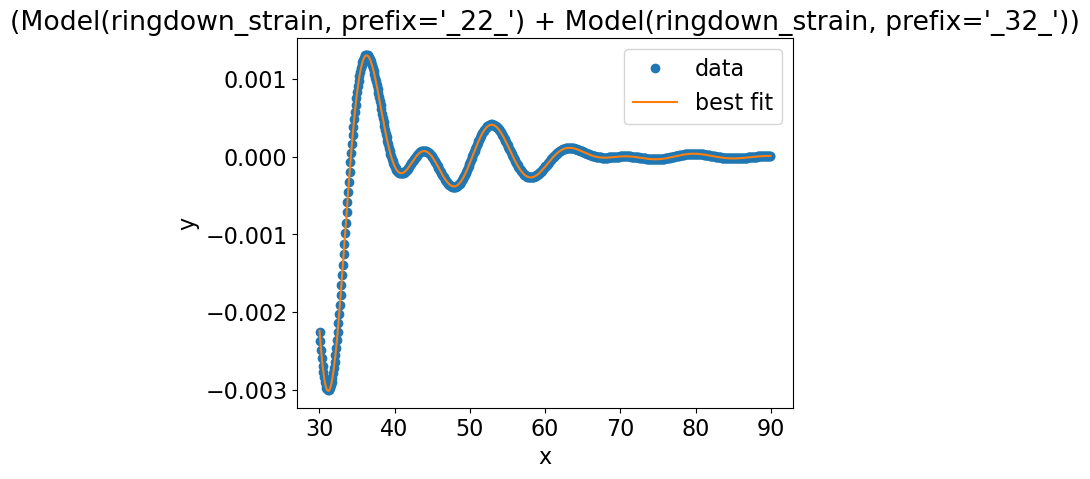

In [1115]:
fr.plot_fit()

<Axes: title={'center': "(Model(ringdown_strain, prefix='_22_') + Model(ringdown_strain, prefix='_32_'))"}, ylabel='residuals'>

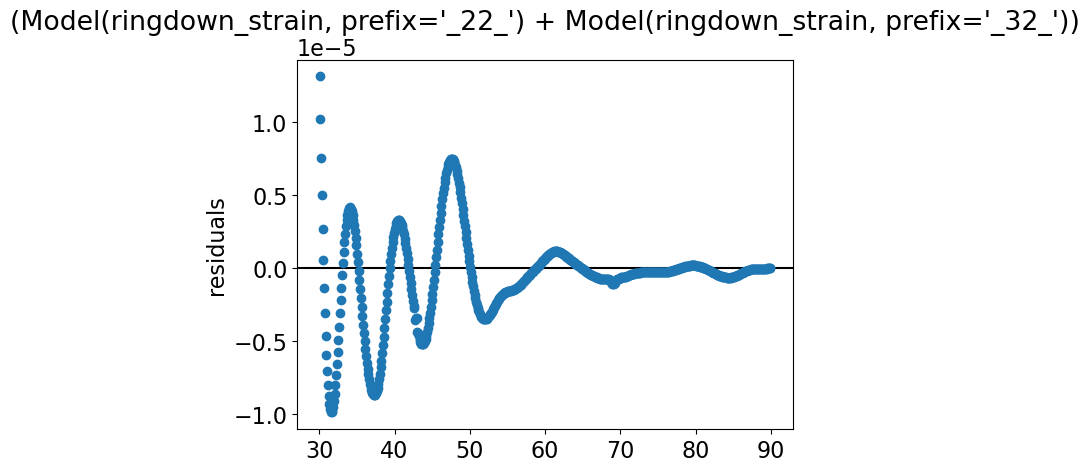

In [1116]:
fr.plot_residuals()

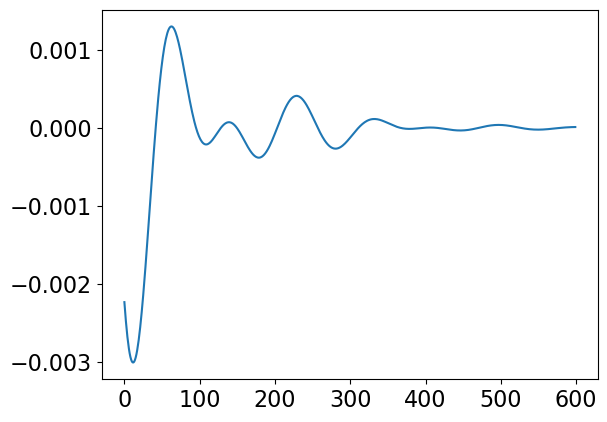

In [1117]:
plt.plot(model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos))

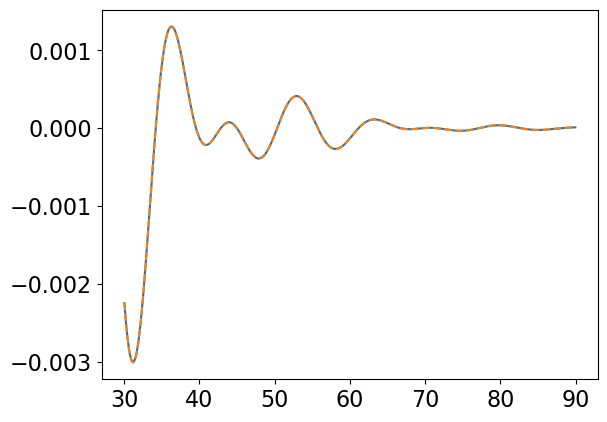

In [1118]:
plt.plot(x, nrls[3,2].strain.real[mask])
# plt.plot(x, fr.eval(), ls='--')
plt.plot(x, model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos), ls='--')


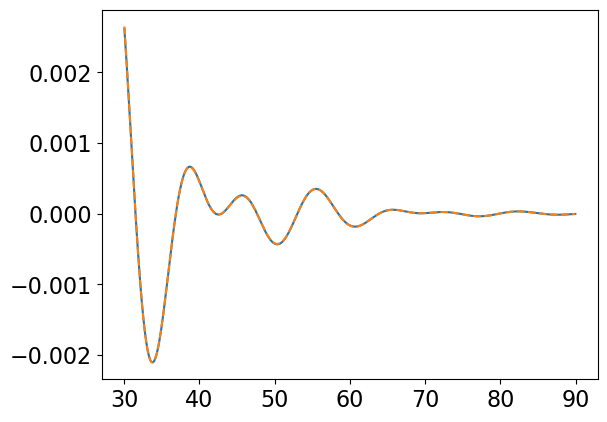

In [1119]:
plt.plot(x, nrls[3,2].strain.imag[mask])
# plt.plot(x, fr.eval(sinusoid_fn=np.sin), ls='--')
plt.plot(x, model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.sin), ls='--')

In [1120]:
# yhat_h = fr.eval() + 1.j * fr.eval(sinusoid_fn=np.sin)

yhat_h_re = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos)
yhat_h_im = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.sin)

yhat_h = yhat_h_re + 1.j * yhat_h_im

yhat_h_abs = np.abs(yhat_h)
yhat_h_phase = np.unwrap(np.angle(yhat_h))

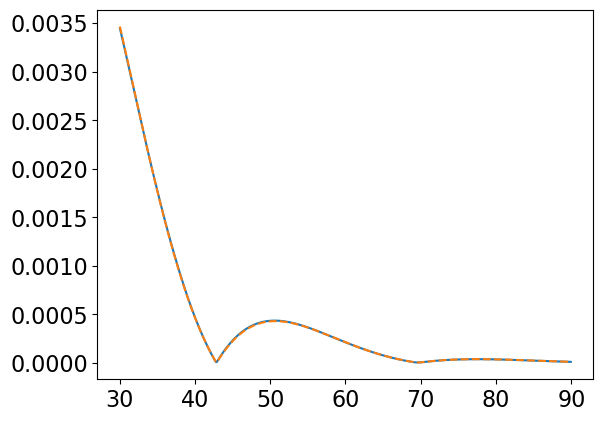

In [1121]:
plt.plot(x, np.abs(nrls[3,2].strain)[mask])
plt.plot(x, yhat_h_abs, ls='--')

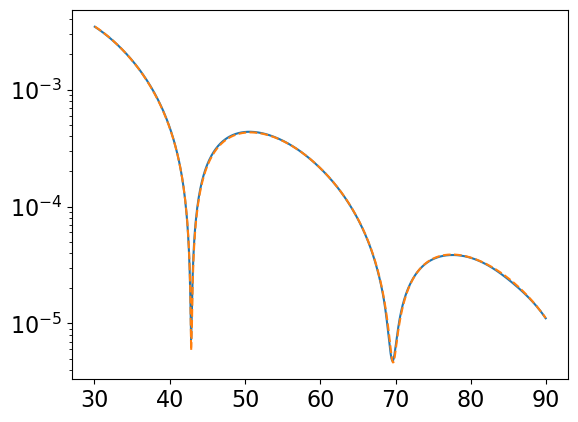

In [1122]:
plt.plot(x, np.abs(nrls[3,2].strain)[mask])
plt.plot(x, yhat_h_abs, ls='--')
plt.yscale('log')

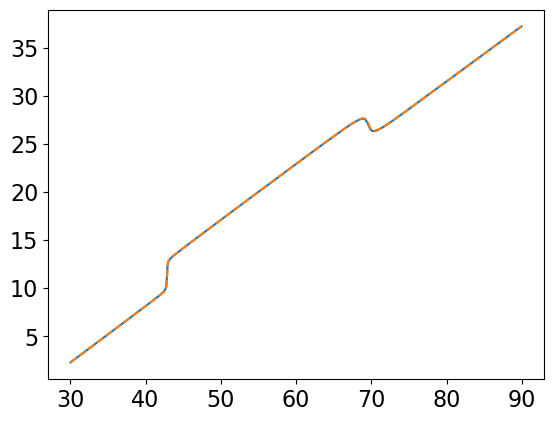

In [1123]:
plt.plot(x, np.unwrap(np.angle(nrls[3,2].strain[mask])))
plt.plot(x, yhat_h_phase, ls='--')

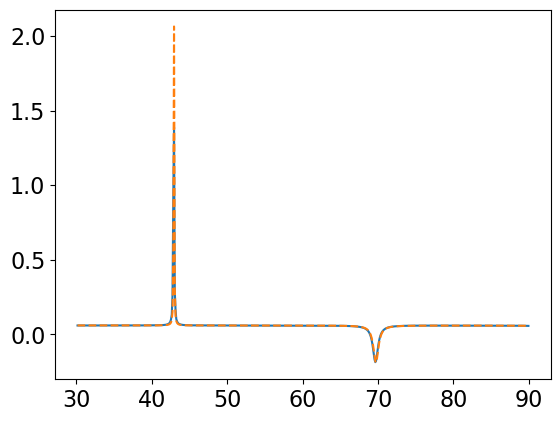

In [1124]:
plt.plot(x[1:], np.diff(np.unwrap(np.angle(nrls[3,2].strain[mask]))))
plt.plot(x[1:], np.diff(yhat_h_phase), ls='--')

In [1125]:
x = nrls[3,2].times
y = nrls[3,2].strain

# mask = (x > -100) & (x < 150)
mask = (x > 0) & (x < 150)
x=x[mask]
y=y[mask]


yhat_h_re = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos)
yhat_h_im = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.sin)

yhat_h = yhat_h_re + 1.j * yhat_h_im

yhat_h_abs = np.abs(yhat_h)

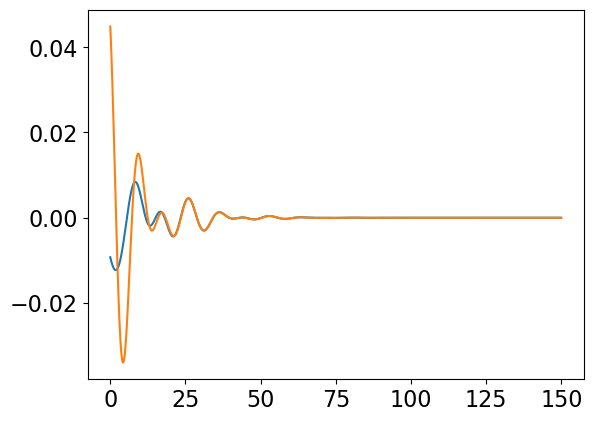

In [1126]:
plt.plot(x, y.real)
plt.plot(x, yhat_h.real)

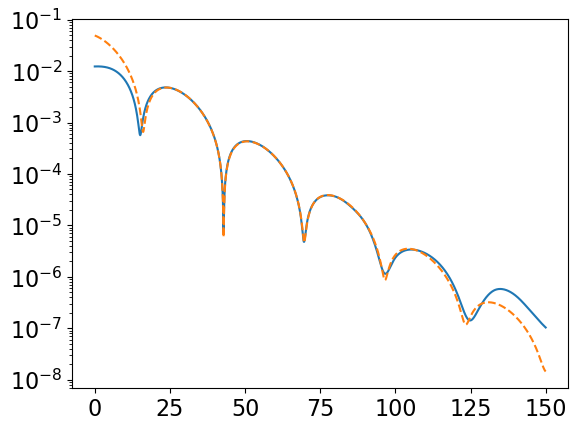

In [1127]:
plt.plot(x, np.abs(y))
plt.plot(x, np.abs(yhat_h), ls='--')
plt.yscale('log')

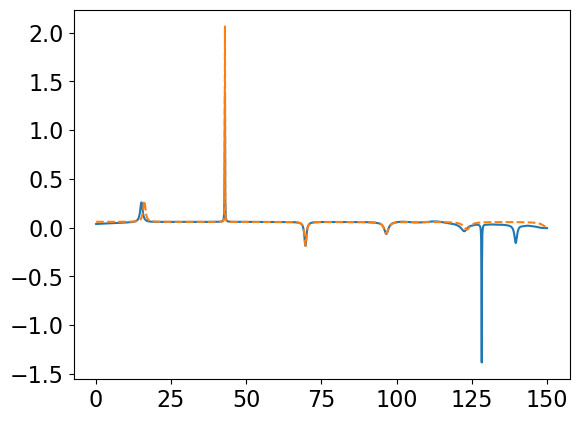

In [1128]:
plt.plot(x[1:], np.diff(np.unwrap(np.angle(y))))
plt.plot(x[1:], np.diff(np.unwrap(np.angle(yhat_h))), ls='--')

(0.0, 0.14514550893718683)

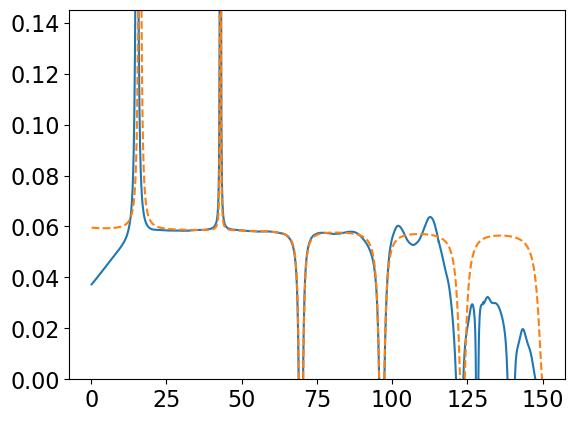

In [1129]:
plt.plot(x[1:], np.diff(np.unwrap(np.angle(y))))
plt.plot(x[1:], np.diff(np.unwrap(np.angle(yhat_h))), ls='--')
plt.ylim(0, get_angular_ringdown_frequency_from_bbh(q, 3, 2)/2/np.pi * 1.3)

# try modelling around the peak

In [1130]:
x = nrls[3,2].times
y_complex = nrls[3,2].strain

# start_time = -100
start_time = -200
end_time = 30

mask = np.where((x >= start_time) & (x <= end_time))
x=x[mask]
y_complex=y_complex[mask]

y_amp = np.abs(y_complex)
y_phase = np.unwrap(np.angle(y_complex))
y_freq = IUS(x, y_phase).derivative()(x)

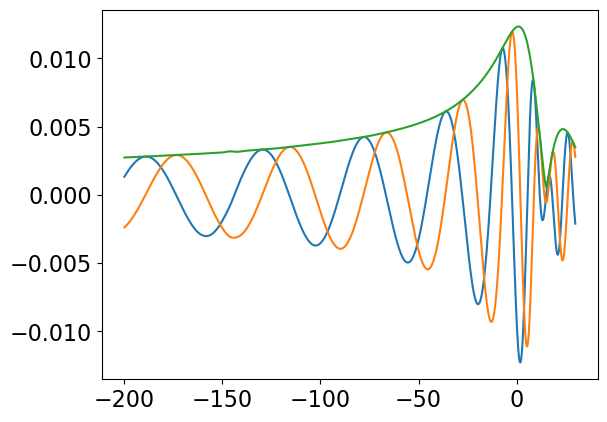

In [1131]:
plt.plot(x, y_complex.real)
plt.plot(x, y_complex.imag)
plt.plot(x, y_amp)

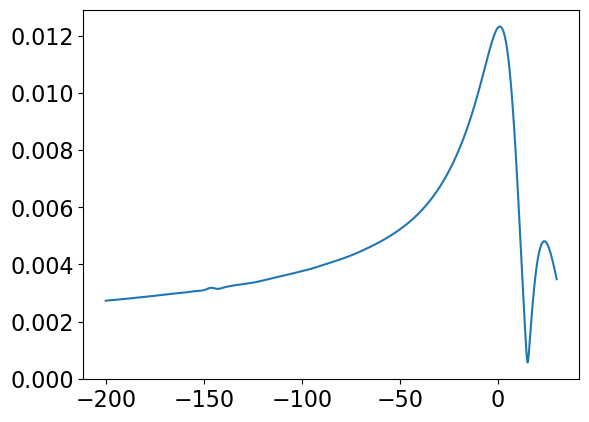

In [1132]:
plt.plot(x, y_amp)

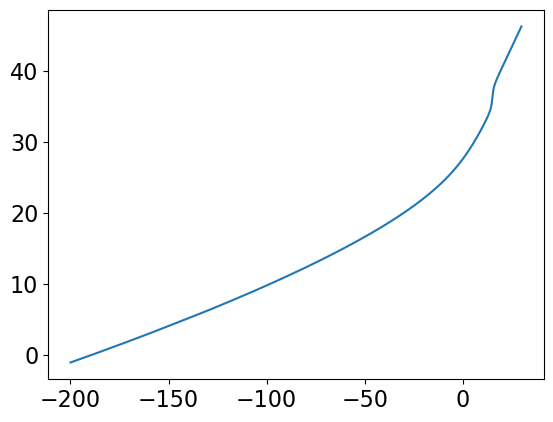

In [1133]:
plt.plot(x, y_phase)

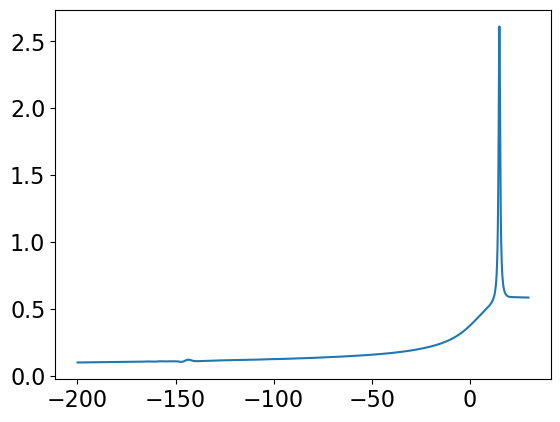

In [1134]:
plt.plot(x, y_freq)

In [1135]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [1136]:
X_train = x[:,np.newaxis]
y_train = y_complex.real

X_train = X_train[::10]
y_train = y_train[::10]

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

0.00648**2 * RBF(length_scale=4.63)

In [1137]:
len(X_train)

230

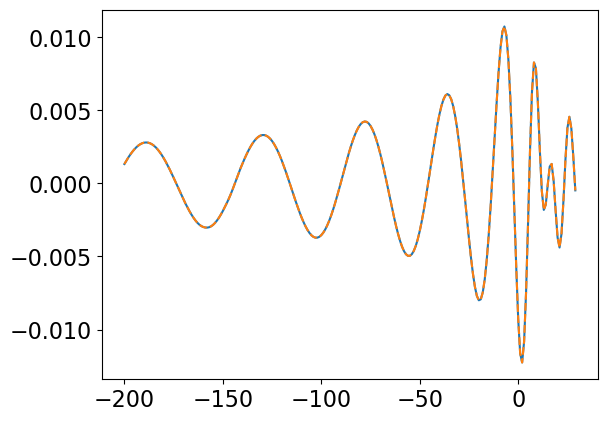

In [1138]:
plt.plot(X_train, y_train)
plt.plot(X_train, gaussian_process.predict(X_train), ls='--')

In [1139]:
x_new = np.arange(start_time, 100, 0.1)
mask = x_new < 30
x_new_merger = x_new[mask]
x_new_ringdown = x_new[~mask]

In [1140]:
%%timeit
gaussian_process.predict(x_new_merger[:,np.newaxis])

3.58 ms ± 76.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1141]:
yhat_h_merger_re = gaussian_process.predict(x_new_merger[:,np.newaxis])
yhat_h_ringdown_re = model_ringdown_strain_32.eval(fr.params, x=x_new_ringdown, sinusoid_fn=np.cos)

In [1142]:
yhat_ = np.concatenate((yhat_h_merger_re, yhat_h_ringdown_re))

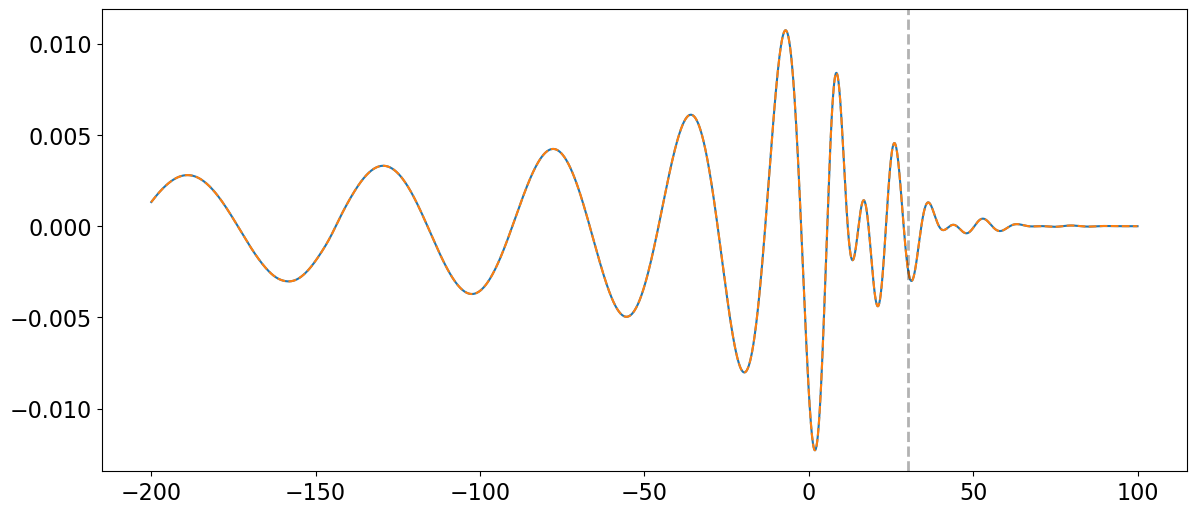

In [1143]:
plt.figure(figsize=(14,6))
mask_nr = (nrls[3,2].times > start_time) & (nrls[3,2].times < 100)
plt.plot(nrls[3,2].times[mask_nr], nrls[3,2].strain.real[mask_nr])
plt.plot(x_new, yhat_, ls='--')
plt.axvline(end_time, c='k', alpha=0.3, lw=2, ls='--')

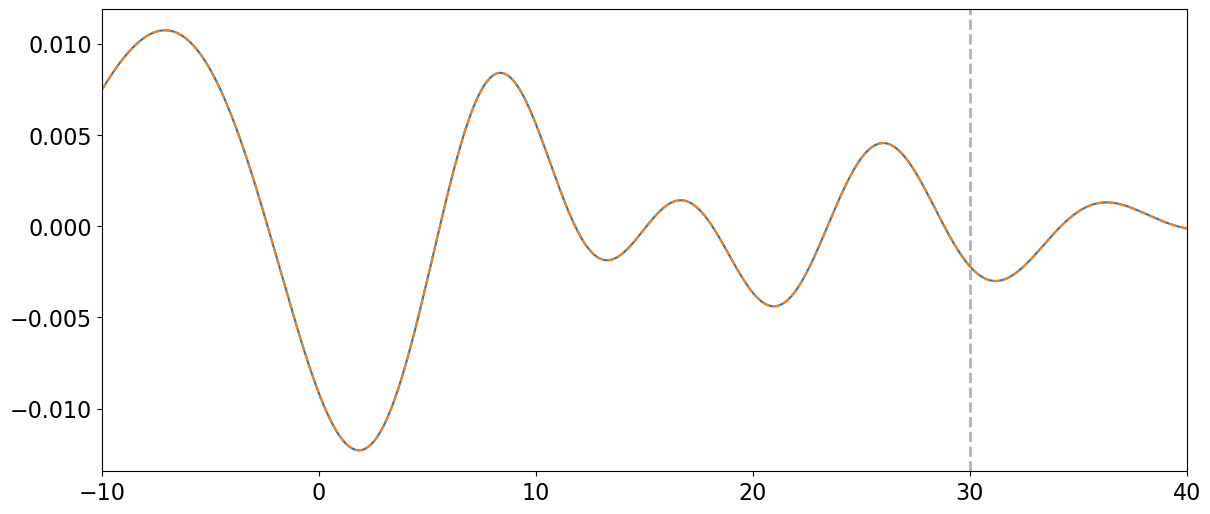

In [1144]:
plt.figure(figsize=(14,6))
mask_nr = (nrls[3,2].times > start_time) & (nrls[3,2].times < 100)
plt.plot(nrls[3,2].times[mask_nr], nrls[3,2].strain.real[mask_nr])
plt.plot(x_new, yhat_, ls='--')
plt.xlim(-10, 40)
plt.axvline(end_time, c='k', alpha=0.3, lw=2, ls='--')